In [40]:
import wandb
import os
import pickle
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd


def get_history(user="kealexanderwang", project="constrained-pnns", query={},
                **kwargs):
    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    dataframes = [run.history(**kwargs) for run in runs]
    if len(runs) == 0:
        return [[],[]]
    else:
        return list(zip(runs, dataframes))


def download_files(user="kealexanderwang", project="constrained-pnns",
                   query={}, save_dir=".", **kwargs):
    """
    Download the files of each run into a new directory for the run.
    Also saves the config dict of the run.
    """
    if not os.path.isdir(save_dir):
        os.mkdir(save_dir)

    api = wandb.Api()
    runs = api.runs(path=f"{user}/{project}", filters=query)
    for run in runs:
        name = run.name
        config = run.config

        run_dir = os.path.join(save_dir, name)
        if not os.path.isdir(run_dir):
            os.mkdir(run_dir)

        with open(os.path.join(run_dir, "config.pkl"), "wb") as h:
            pickle.dump(config, h)

        files = run.files()
        for file in files:
            file.download(root=run_dir)
    return

In [41]:
from pytorch_lightning import Trainer
from pl_trainer import DynamicsModel, SaveTestLogCallback
import os

def load_model_from_run(run, save_dir="/tmp"):
    name = run.display_name
    ckpt_save_path = os.path.join(save_dir, name)
    if not os.path.exists(ckpt_save_path):
        os.makedirs(ckpt_save_path)
     
    ckpts = sorted([f for f in run.files() if "checkpoints" in f.name])
    if len(ckpts) == 0:
        raise RuntimeError(f"Run {name} has no checkpoints!")
    # pick latest checkpoint if available
    last_ckpt = ckpts[-1]
    last_ckpt.download(replace=True, root=ckpt_save_path)
        
    ckpt_path = os.path.join(ckpt_save_path, last_ckpt.name)
    # Uncommet if you need the trainer
    pl_trainer = Trainer(resume_from_checkpoint=ckpt_path,logger=False)
    pl_model = DynamicsModel.load_from_checkpoint(ckpt_path)
    
    import pprint 
    pp = pprint.PrettyPrinter(indent=4)
    print("--------------------------------")
    print("Model Hyperparameters:")
    pp.pprint(vars(pl_model.hparams))
    print("--------------------------------")
    return pl_trainer, pl_model

def load_file_from_run(run, filename, save_dir="/tmp", replace=False):
    name = run.display_name
    save_path = os.path.join(save_dir, name)
    if not os.path.exists(save_path):
        os.makedirs(save_path)
    for f in run.files():
        if filename in f.name:
            file_path = os.path.join(save_path, f.name)
            if not os.path.exists(file_path):
                f.download(replace=replace, root=save_path)
            else:
                print("File already exists")
            return file_path
    raise ValueError("File not found in run!")

In [42]:
# See https://docs.wandb.com/library/reference/wandb_api for how to write queries

# Pendulum data-efficiency
query = {"$and": [{"$or": [{"tags": "small-data-efficiency"}, {"tags": "data-efficiency"}]},
                  {"state": "finished"},
                  {"config.body_args": [2]},
                  {"config.body_class": "ChainPendulum"},
                  {"config.network_class": {"$ne": "LNN"}},
                  {"config.network_class": {"$ne": "DeLaN"}}
                 ]}

runs, histories = zip(*get_history(query=query))

In [44]:
import torch

labels = []
series = []

for run in runs:
    test_log_path = load_file_from_run(run, "test_log.pt")
    test_log = torch.load(test_log_path)

    pred_zts = test_log["pred_zts"]
    true_zts = test_log["true_zts"]
    pert_zts = test_log["pert_zts"]

    network_class = run.config["network_class"]
    n_train = run.config["n_train"]
    #n_train = (r"$N_{train}$=", f"{n_train}")
    n_train = n_train

    rel_err_pred_true = ((pred_zts - true_zts).pow(2).sum((2, 3, 4)) / (pred_zts + true_zts).pow(2).sum((2,3,4))).sqrt()
    rel_err_pert_true = ((pert_zts - true_zts).pow(2).sum((2, 3, 4)) / (pert_zts + true_zts).pow(2).sum((2,3,4))).sqrt()

    #avg_rel_err_pred = rel_err_pred_true.mean(0).numpy()
    #avg_rel_err_pert = rel_err_pert_true.mean(0).numpy()
    avg_rel_err_pred = rel_err_pred_true.cpu().numpy()
    avg_rel_err_pert = rel_err_pert_true.cpu().numpy()

    # turn into list of series from batch of series   
    series += avg_rel_err_pred.tolist()
    labels += [(n_train, network_class, "avg_rel_err_pred", batch) for batch in range(len(avg_rel_err_pred))]
    
    series += avg_rel_err_pert.tolist()
    labels += [(n_train, network_class, "avg_rel_err_pert", batch) for batch in range(len(avg_rel_err_pert))]

File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists
File already exists


In [45]:
#index = pd.MultiIndex.from_tuples(labels, names =('Body', 'Network', "Series"))
levels = ['n_train', 'Network', "Series", "Batch"]
index = pd.MultiIndex.from_tuples(labels, names=levels)
df = pd.DataFrame(series, index=index).reset_index()

In [46]:
df.head()

,n_train,Network,Series,Batch,0,1,2,3,4,5,...,90,91,92,93,94,95,96,97,98,99
0,100,CHNN,avg_rel_err_pred,0,1.820283e-12,0.000082,0.000153,0.000205,0.000236,0.000245,...,0.006211,0.005872,0.005546,0.005248,0.004983,0.004753,0.004557,0.004389,0.004245,0.004119
1,100,CHNN,avg_rel_err_pred,1,0.000000e+00,0.000135,0.000252,0.000355,0.000449,0.000535,...,0.003532,0.003601,0.003665,0.003731,0.003819,0.003964,0.004231,0.004701,0.005398,0.006132
2,100,CHNN,avg_rel_err_pred,2,0.000000e+00,0.000138,0.000279,0.000421,0.000565,0.000710,...,0.009205,0.009555,0.009907,0.010252,0.010580,0.010882,0.011155,0.011396,0.011606,0.011787
3,100,CHNN,avg_rel_err_pred,3,1.468485e-08,0.000045,0.000087,0.000111,0.000105,0.000089,...,0.015850,0.015945,0.016120,0.016371,0.016695,0.017075,0.017500,0.017995,0.018683,0.019879
4,100,CHNN,avg_rel_err_pred,4,2.147322e-08,0.000078,0.000188,0.000346,0.000545,0.000760,...,0.812448,0.794449,0.806472,0.840297,0.884102,0.927116,0.961015,0.980812,0.985209,0.976081


In [47]:
dt = run.config["dt"]
integration_time = run.config["integration_time"]
chunk_len = run.config["chunk_len"] * dt
n_timesteps = int(integration_time / dt)

In [48]:
df = df.rename(columns={i: dt * i for i in range(n_timesteps)})

In [49]:
df = pd.melt(df, id_vars=levels, var_name="time")

In [50]:
df = df.sort_values(by=levels)

In [51]:
sns.set(font_scale=1.25)
sns.set_style('whitegrid')
sns.set_palette(sns.color_palette("Set1", n_colors=6, desat=.67))
#import matplotlib as mpl
#mpl.rcParams['figure.dpi'] = 1000

In [56]:
df["n_train"].unique()

array([  20,   50,   75,  100,  200,  400,  800, 1600])

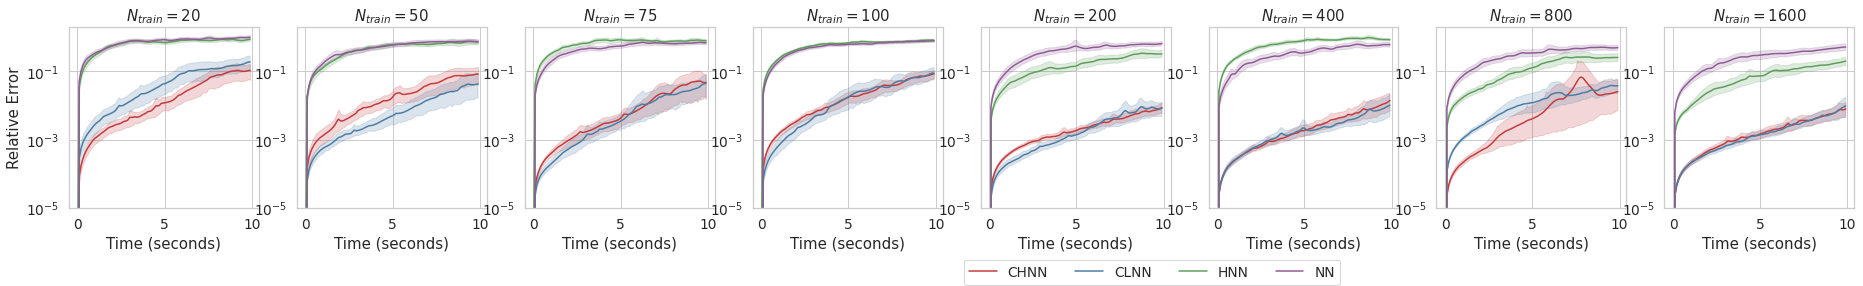

In [55]:
n_plots = len(df["n_train"].unique())
fig, axes = plt.subplots(ncols=n_plots, figsize=(4 * n_plots, 4))
for n_train, ax in zip(df["n_train"].unique(), axes):
    data = df.loc[(df["Series"] == "avg_rel_err_pred") & (df["n_train"] == n_train)]
    sns.lineplot(data=data, x="time", y="value", hue="Network", ax=ax, ci=95)
    ax.set(yscale="log", xlabel="Time (seconds)", title=r"$N_{train}=$" + f"{n_train}", ylim=(1e-5, 2))
    ax.set(ylabel="")
    ax.legend().remove()
axes[0].set(ylabel="Relative error")
handles, labels = axes[-1].get_legend_handles_labels()
labels = labels[1:] # Get rid of legend title
#fig.legend(handles, labels, loc='upper center')
fig.subplots_adjust(bottom=0.25)
fig.legend(labels=labels, bbox_to_anchor=(0., 0., 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1)

In [57]:
df.head()

,n_train,Network,Series,Batch,time,value
2700,20,CHNN,avg_rel_err_pert,0,0,0.000043
9900,20,CHNN,avg_rel_err_pert,0,0.1,0.000044
17100,20,CHNN,avg_rel_err_pert,0,0.2,0.000045
24300,20,CHNN,avg_rel_err_pert,0,0.3,0.000047
31500,20,CHNN,avg_rel_err_pert,0,0.4,0.000051


In [82]:
df_series = df.pivot_table(index=["n_train", "Network", "Series", "Batch"], columns="time", values="value")
y = df_series.to_numpy()
geom_mean = np.exp(np.trapz(np.log(y + 1e-8), dx=dt, axis=-1) / integration_time)
df_geom_mean = pd.DataFrame(index=df_series.index, data=geom_mean, columns=["Geometric Mean"])
df_geom_mean = df_geom_mean.reset_index()

In [112]:
df_geom_mean

,n_train,Network,Series,Batch,Geometric Mean
0,20,CHNN,avg_rel_err_pert,0,0.000053
1,20,CHNN,avg_rel_err_pert,1,0.000107
2,20,CHNN,avg_rel_err_pert,2,0.000096
3,20,CHNN,avg_rel_err_pert,3,0.000038
4,20,CHNN,avg_rel_err_pert,4,0.000071
...,...,...,...,...,...
6395,1600,NN,avg_rel_err_pred,95,0.046326
6396,1600,NN,avg_rel_err_pred,96,0.046651
6397,1600,NN,avg_rel_err_pred,97,0.045489
6398,1600,NN,avg_rel_err_pred,98,0.241800


In [113]:
body_args = tuple(run.config["body_args"])
if len(body_args) == 0:
    body_args = ""
elif len(body_args) == 1:
    body_args = f"({body_args[0]})"
else:
    body_args = f"{body_args}"
body = f"{run.config['body_class']}{body_args}"

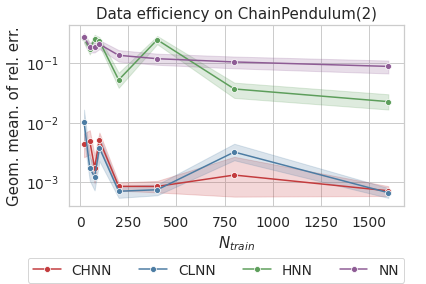

In [114]:
fig, ax = plt.subplots()
sns.lineplot(data=df_geom_mean, x="n_train", y="Geometric Mean",
             ci=95, hue="Network", ax=ax,
             markers=["o"]*df_geom_mean["Network"].nunique(),
             #markers=True,
             dashes=False,
             style="Network")
ax.set(yscale="log", ylabel="Geom. mean. of rel. err.", xlabel=r"$N_{train}$",
       title=f"Data efficiency on {body}")
ax.legend().remove()
_, labels = ax.get_legend_handles_labels()
labels = labels[1:] # Remove title
fig.subplots_adjust(bottom=0.25)
fig.legend(labels=labels, bbox_to_anchor=(0., 0., 1.0, 0.1), loc="lower center", ncol=len(labels), borderaxespad=0.1)

In [115]:
fig.savefig("data-efficiency.pdf", bbox_inches="tight")